# Modeling

In [3]:
fit_quarter="2012Q1"
validate_quarter="2012Q2"
directory = "Data/"

In [4]:
import pandas as pd
pd.set_option("display.max_row",500)
pd.set_option("display.max_columns",500)

import warnings
warnings.filterwarnings("ignore")

import numpy as np

## Import File
I created a function to build datasets given a particular quarter.  This is useful for training a model on one dataset and testing models on other datasets.  This function also allows for taking a random sample from the dataset.  I found it useful to train a model on a smaller sample, say 10%-25%.  Fitting models ran much faster on smaller sets of data.  I also noticed very little degradation of performance (if any) with these sample sizes.  I did notice degradation at sample sizes smaller than 10%.

In [5]:
def get_xy(quarter, frac):
    # read the file
    filename=directory+"Adjusted_Acquisition_"+quarter+".txt"
    col_types={"LOAN_ID":object,"NUM_BO":int,"NUM_UNIT":int,"ZIP_3":object,"MI_TYPE":object}
    df = pd.read_csv(filename, sep=",",dtype=col_types)
    
    df=df.sample(frac=frac, random_state=0)
    
    # numerics
    features_to_use = ["ORIG_RT","ORIG_AMT","ORIG_TRM","OLTV","OCLTV","DTI","CSCORE_B","NUM_BO","NUM_UNIT"]
    X = df[features_to_use]

    # create dummy variables for categoricals
    cat_vars = ["ORIG_CHN","FTHB_FLG","PURPOSE","PROP_TYP","OCC_STAT","MI_TYPE","RELOCATION_FLG"] #,"STATE"
    X2 = pd.get_dummies(df[cat_vars])

    # join X and X2
    X = X.join(X2)

    # build the target
    y = df["target"]

    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y = le.fit_transform(y)
    
    return X, y

X,y = get_xy(fit_quarter,0.1)
features_to_use = X.columns

## Build Training and Testing Data
My aim is to fit models on a subset of a particular quarter's data.  During this fitting, I'm further breaking the data into training and testing splits.  I will then validate the final model on the entirety of another dataset.

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0,stratify=y)

## Model Building

#### The Models to be Used

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

clfs = {'dt': DecisionTreeClassifier(random_state=0)
         ,'rf': RandomForestClassifier(random_state=0)
         ,'mlp': MLPClassifier(random_state=0)
#       ,'svc': SVC(random_state=0)
        ,'lr': LogisticRegression(random_state=0)
#        ,'knn': KNeighborsClassifier()
        ,'lsvc':LinearSVC(random_state=0)
       }

#### Build Pipelines for the Models

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe_clfs = {}

for name, clf in clfs.items():
    pipe_clfs[name] = Pipeline([('StandardScaler', StandardScaler()), ('clf', clf)])

#### Create Parameter Grids for Models

In [10]:
param_grids = {}

param_grids['lr'] = [{'clf__solver': ['liblinear'],
                      'clf__class_weight':["balanced"],
                      'clf__C': [10 ** i for i in range(-5, 1)]}]

param_grids['mlp'] = [{'clf__hidden_layer_sizes': [10, 100],
                       'clf__activation': ['identity', 'logistic', 'tanh', 'relu']}]

param_grids['dt'] = [{'clf__min_samples_split': [2],
                      'clf__class_weight':["balanced"]}]

param_grids['rf'] = [{'clf__n_estimators': [10, 1000],
                      'clf__class_weight':["balanced"]}]

param_grids['svc'] = [{'clf__C': [1],
                       #'clf__gamma': [0.01, 1, 100],
                       'clf__class_weight':["balanced"],
                       'clf__kernel': ['linear']}]

param_grids['lsvc'] = [{'clf__C': [0.0001,1],
                       #'clf__gamma': [0.01, 1, 100],
                       'clf__class_weight':["balanced"],
                       }]

param_grids['knn'] = [{'clf__n_neighbors':[3,100],
                      'clf__weights':['distance','uniform']}]


#### Perform GridSearch to Find Optimal Models/Parameters
I'm using the "recall" scoring mechanism as my goal is to identify as many defaults as possible.  This will lead to overclassification of loans that are probable for default.  This could be a useful tool for risk managers inside a bank, FNMA, or investment shop.  The "recall" scoring specifically gives the model's recall on the "positive" class, in this case the defaults.  Hence, I'm training the models to have the highest ability to identify/predict defaults.

The GridSearch class provides functionality to provide the fitting time.  I found the SVC and MLP models to a long time.  MLP did so with very limited results.  The SVC model performed quite well.

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# The list of [best_score_, best_params_, best_estimator_]
best_score_param_estimators = []

# For each classifier
for name in pipe_clfs.keys():
        # GridSearchCV
    gs = GridSearchCV(estimator=pipe_clfs[name],
                      param_grid=param_grids[name],
                      scoring="recall",
                      n_jobs=-1,
                      cv=StratifiedKFold(n_splits=3,
                                         shuffle=True,
                                         random_state=0))
    
    # Fit the pipeline
    gs = gs.fit(X_train, y_train)
    
    # Update best_score_param_estimators
    best_score_param_estimators.append([name, gs.best_score_, gs.best_params_, gs.best_estimator_])
    
    print(name,gs.best_score_,gs.best_params_,
          np.sum(gs.cv_results_['mean_fit_time']),gs.cv_results_['mean_fit_time']) 

dt 0.025445178501061486 {'clf__class_weight': 'balanced', 'clf__min_samples_split': 2} 0.1584314505259196 [0.15843145]
rf 0.0 {'clf__class_weight': 'balanced', 'clf__n_estimators': 10} 15.055898507436115 [ 0.18773452 14.86816398]
mlp 0.002544586321988341 {'clf__activation': 'tanh', 'clf__hidden_layer_sizes': 100} 49.20115351676941 [ 0.95206157  1.3821485   2.27962104  5.31822824  4.82555286 15.52105578
  4.27260439 14.64988112]
lr 0.9211198781748272 {'clf__C': 1e-05, 'clf__class_weight': 'balanced', 'clf__solver': 'liblinear'} 2.2955473264058432 [0.10652256 0.13311728 0.36749919 0.59520364 0.65379365 0.439411  ]
lsvc 0.7964375449132753 {'clf__C': 0.0001, 'clf__class_weight': 'balanced'} 6.949352343877157 [0.33154384 6.6178085 ]


In [12]:
# Sort best_score_param_estimators in descending order of the best_score_
best_score_param_estimators = sorted(best_score_param_estimators, 
                                     key=lambda x : x[1], 
                                     reverse=True)

#### Function to Show Model Results

In [25]:
def view_results(y_true,y_pred):
    print("Confusion Matrix:")
    from sklearn.metrics import confusion_matrix
    print(confusion_matrix(y_true, y_pred))
    print()

    print("Classification Report:")
    from sklearn.metrics import classification_report
    print(classification_report(y_true, y_pred))
    print()

    print("Receiver operating characteristic:")
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)

    import matplotlib.pyplot as plt
    import seaborn as sns
    main_color = sns.color_palette("Set2")[0]
    default_color = sns.color_palette("Set2")[1]

    plt.figure()
    plt.title("ROC Curve")
    plt.plot(fpr, tpr, color=main_color)
    plt.plot([0, 1], [0, 1],color=default_color)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    from sklearn.metrics import roc_auc_score

    print("AUC:",str(roc_auc_score(y_true, y_pred)))

## Run Models on Testing Data

lr
<class 'sklearn.linear_model.logistic.LogisticRegression'>
{'clf__C': 1e-05, 'clf__class_weight': 'balanced', 'clf__solver': 'liblinear'}

Confusion Matrix:
[[10712  8233]
 [   19   149]]

Classification Report:
             precision    recall  f1-score   support

          0       1.00      0.57      0.72     18945
          1       0.02      0.89      0.03       168

avg / total       0.99      0.57      0.72     19113


Receiver operating characteristic:


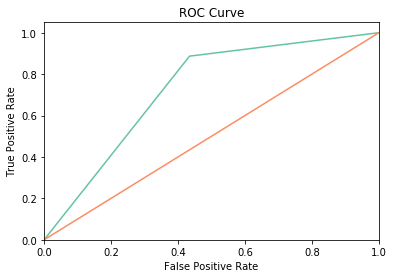

AUC: 0.7261654978697734

lsvc
<class 'sklearn.svm.classes.LinearSVC'>
{'clf__C': 0.0001, 'clf__class_weight': 'balanced'}

Confusion Matrix:
[[14341  4604]
 [   35   133]]

Classification Report:
             precision    recall  f1-score   support

          0       1.00      0.76      0.86     18945
          1       0.03      0.79      0.05       168

avg / total       0.99      0.76      0.85     19113


Receiver operating characteristic:


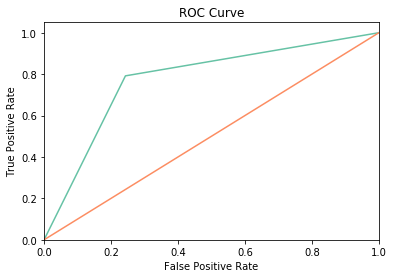

AUC: 0.7743237001847452

dt
<class 'sklearn.tree.tree.DecisionTreeClassifier'>
{'clf__class_weight': 'balanced', 'clf__min_samples_split': 2}

Confusion Matrix:
[[18779   166]
 [  161     7]]

Classification Report:
             precision    recall  f1-score   support

          0       0.99      0.99      0.99     18945
          1       0.04      0.04      0.04       168

avg / total       0.98      0.98      0.98     19113


Receiver operating characteristic:


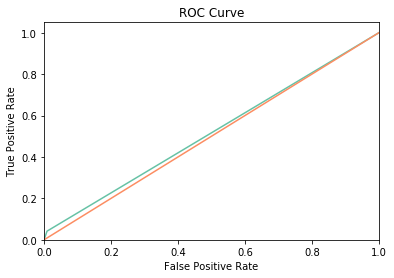

AUC: 0.5164522301398786

mlp
<class 'sklearn.neural_network.multilayer_perceptron.MLPClassifier'>
{'clf__activation': 'tanh', 'clf__hidden_layer_sizes': 100}

Confusion Matrix:
[[18945     0]
 [  168     0]]

Classification Report:
             precision    recall  f1-score   support

          0       0.99      1.00      1.00     18945
          1       0.00      0.00      0.00       168

avg / total       0.98      0.99      0.99     19113


Receiver operating characteristic:


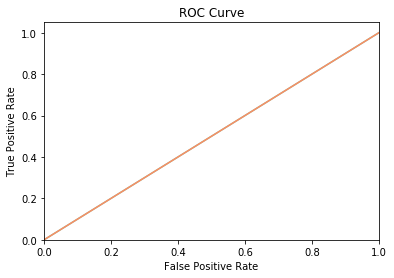

AUC: 0.5

rf
<class 'sklearn.ensemble.forest.RandomForestClassifier'>
{'clf__class_weight': 'balanced', 'clf__n_estimators': 10}

Confusion Matrix:
[[18944     1]
 [  168     0]]

Classification Report:
             precision    recall  f1-score   support

          0       0.99      1.00      1.00     18945
          1       0.00      0.00      0.00       168

avg / total       0.98      0.99      0.99     19113


Receiver operating characteristic:


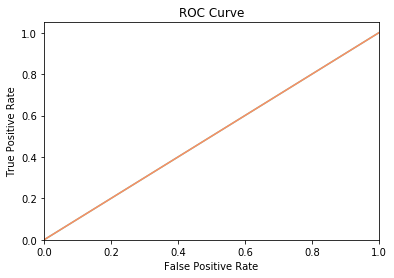

AUC: 0.4999736078120876



In [26]:
for best_score_param_estimator in best_score_param_estimators:
    print(best_score_param_estimator[0])
    print(type(best_score_param_estimator[3].named_steps['clf']))
    print(best_score_param_estimator[2])
    print()
    
    pipeline = best_score_param_estimator[3]
    y_test_pred = pipeline.predict(X_test)
    view_results(y_test, y_test_pred)
    print()

## Validation on a Different Dataset (2012Q2)

lr
<class 'sklearn.linear_model.logistic.LogisticRegression'>
{'clf__C': 1e-05, 'clf__class_weight': 'balanced', 'clf__solver': 'liblinear'}

Confusion Matrix:
[[292376 244829]
 [   487   3962]]

Classification Report:
             precision    recall  f1-score   support

          0       1.00      0.54      0.70    537205
          1       0.02      0.89      0.03      4449

avg / total       0.99      0.55      0.70    541654


Receiver operating characteristic:


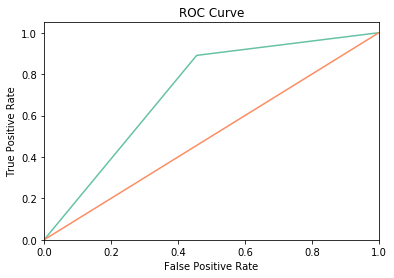

AUC: 0.717395627542472

lsvc
<class 'sklearn.svm.classes.LinearSVC'>
{'clf__C': 0.0001, 'clf__class_weight': 'balanced'}

Confusion Matrix:
[[402728 134477]
 [  1055   3394]]

Classification Report:
             precision    recall  f1-score   support

          0       1.00      0.75      0.86    537205
          1       0.02      0.76      0.05      4449

avg / total       0.99      0.75      0.85    541654


Receiver operating characteristic:


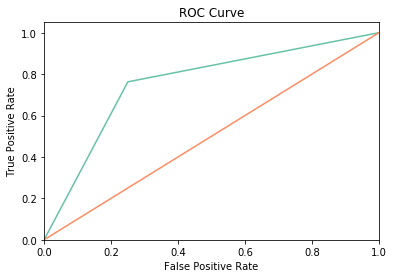

AUC: 0.7562704519692596

dt
<class 'sklearn.tree.tree.DecisionTreeClassifier'>
{'clf__class_weight': 'balanced', 'clf__min_samples_split': 2}

Confusion Matrix:
[[532772   4433]
 [  4294    155]]

Classification Report:
             precision    recall  f1-score   support

          0       0.99      0.99      0.99    537205
          1       0.03      0.03      0.03      4449

avg / total       0.98      0.98      0.98    541654


Receiver operating characteristic:


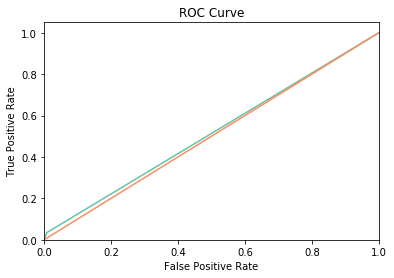

AUC: 0.5132936594394558

mlp
<class 'sklearn.neural_network.multilayer_perceptron.MLPClassifier'>
{'clf__activation': 'tanh', 'clf__hidden_layer_sizes': 100}

Confusion Matrix:
[[537205      0]
 [  4449      0]]

Classification Report:
             precision    recall  f1-score   support

          0       0.99      1.00      1.00    537205
          1       0.00      0.00      0.00      4449

avg / total       0.98      0.99      0.99    541654


Receiver operating characteristic:


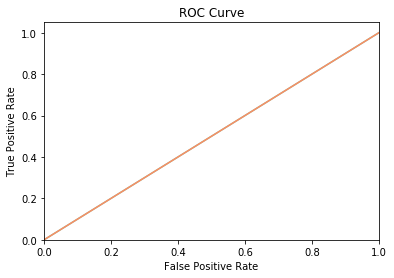

AUC: 0.5

rf
<class 'sklearn.ensemble.forest.RandomForestClassifier'>
{'clf__class_weight': 'balanced', 'clf__n_estimators': 10}

Confusion Matrix:
[[537181     24]
 [  4447      2]]

Classification Report:
             precision    recall  f1-score   support

          0       0.99      1.00      1.00    537205
          1       0.08      0.00      0.00      4449

avg / total       0.98      0.99      0.99    541654


Receiver operating characteristic:


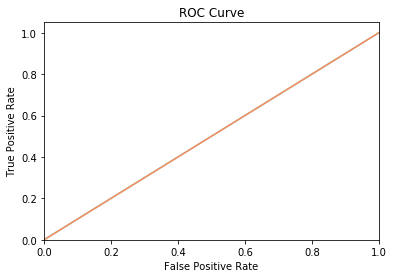

AUC: 0.5002024317699149



In [27]:
X_validation, y_validation = get_xy(validate_quarter,1.0)

for best_score_param_estimator in best_score_param_estimators:
    print(best_score_param_estimator[0])
    print(type(best_score_param_estimator[3].named_steps['clf']))
    print(best_score_param_estimator[2])
    print()
    
    pipeline = best_score_param_estimator[3]
    y_pred = pipeline.predict(X_validation[features_to_use])
    view_results(y_validation,y_pred)
    print()

## Feature Importance

#### Function to Show Feature Importance

In [16]:
# https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d
import matplotlib.pyplot as plt
import seaborn as sns

main_color = sns.color_palette("Set2")[0]
default_color = sns.color_palette("Set2")[1]

def plot_coefficients(classifier, feature_names, top_features=10):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    
    # create plot
    plt.figure(figsize=(15, 5))
    colors = [default_color if c < 0 else main_color for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.title(classifier)
    plt.show()

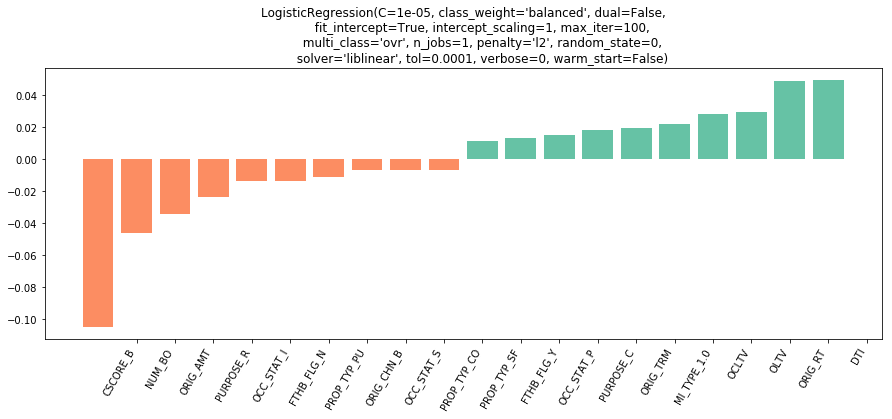

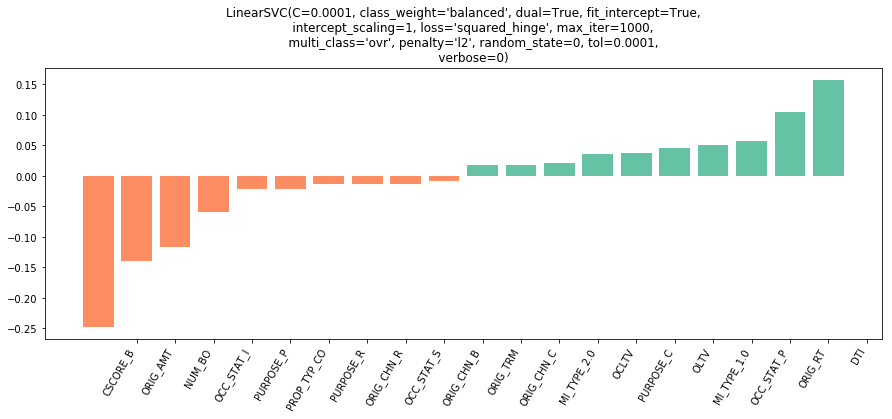

In [17]:
feature_names = X_train.columns

clf = best_score_param_estimators[0][3].named_steps['clf']
plot_coefficients(clf, feature_names)

clf = best_score_param_estimators[1][3].named_steps['clf']
plot_coefficients(clf, feature_names)

## Prediction Analysis for Logistic Regression

#### Functions to Plot Predicted Probabilities
Adapted from midterm

In [18]:
def get_distribution(clf, X, y, feature, class_):
    """
    Calculate the probability distribution of a class based on a feature
    :param clf: the logistic regression classifier
    :param X: the feature vector
    :param y: the target vector
    :param feature: a feature
    :param class_: a class label of the target
    :return: the probability distribution, which is a dictionary 
             where the key is the value of the feature and value the probability:
             distribution = {val_1: proba_1, val_2: proba_2, ..., val_n: proba_n}
             
    """
    
    # Implement me
    
    # create the distribution dictionary to be built below
    distribution = {}
    
    # get index of class_ to be used to capture correct predicted probability
    class_index = class_
    
    # create matrix with just values for the specified feature
    feature_vals = np.zeros(X.shape)
    feature_idx = list(features_to_use).index(feature)
    feature_vals[:,feature_idx] = X[feature].values
      
    # build the distribution dictionary
    for i in range(feature_vals.shape[0]):
        row_to_predict = feature_vals[i].reshape(1, -1)
        y_pred = clf.predict_proba(row_to_predict)
        distribution.update({feature_vals[i,feature_idx] : y_pred[0,class_index]})
    
    return distribution


def plot_distribution(distribution, feature, class_, color="skyblue"):
    """
    Plot the probability distribution of a class based on the feature
    :param distribution: the probability distribution, which is a dictionary 
                         where the key is the value of the feature and value the probability:
                         distribution = {val_1: proba_1, val_2: proba_2, ..., val_n: proba_n}
    :param feature: a feature
    :param class_: a class label of the target
    """
    
    keys = list(distribution.keys())
    vals = list(distribution.values())
    plt.plot(keys,vals,color=color)
    
    plt.xlabel('Feature value')
    plt.ylabel('Probability')
    plt.title(feature, loc='center')

### Predicted Probabilities by Credit Score by Default/No Default

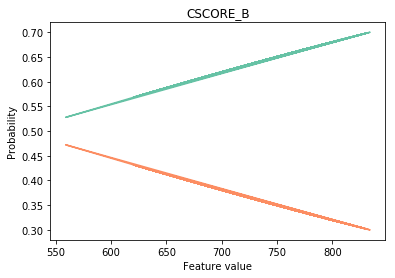

In [29]:
# Get the distribution
clf = best_score_param_estimators[0][3]
distribution = get_distribution(clf, X_train, y_train, "CSCORE_B", 0)

# Plot the distribution
plot_distribution(distribution, "CSCORE_B", 0, main_color)

# Get the distribution
clf = best_score_param_estimators[0][3]
distribution = get_distribution(clf, X_train, y_train, "CSCORE_B", 1)

# Plot the distribution
plot_distribution(distribution, "CSCORE_B", 1, default_color)

### Loan Level Predicted Probabilities Analysis

In [20]:
# probability on incorrect predictions (show examples of correct/incorrect)
clf = best_score_param_estimators[0][3]
pred_prob = pd.DataFrame(clf.predict_proba(X_validation),columns=["non_default prob","default prob"])
pred = pd.DataFrame(clf.predict(X_validation),columns=["prediction"])
loan_df = pd.concat([X_validation,pd.DataFrame(y_validation,columns=["target"]),pred_prob,pred],axis=1)

print("Most Likely to Default")
print(loan_df.sort_values(by=["default prob"],ascending=False).head(4).T)
print()
print("Least Likely to Default")
print(loan_df.sort_values(by=["default prob"],ascending=True).head(4).T)

Most Likely to Default
                         528001        87033         501433         357116
ORIG_RT                4.375000      3.875000      3.375000       3.125000
ORIG_AMT          530000.000000  85000.000000  86000.000000  145000.000000
ORIG_TRM             360.000000    360.000000    180.000000     180.000000
OLTV                  85.000000     80.000000     54.000000      54.000000
OCLTV                 85.000000     80.000000     54.000000      54.000000
DTI                   40.000000     26.000000     16.000000      32.000000
CSCORE_B             793.000000    783.000000    823.000000     815.000000
NUM_BO                 2.000000      2.000000      1.000000       1.000000
NUM_UNIT               1.000000      1.000000      1.000000       1.000000
ORIG_CHN_B             0.000000      0.000000      0.000000       0.000000
ORIG_CHN_C             0.000000      1.000000      0.000000       0.000000
ORIG_CHN_R             1.000000      0.000000      1.000000       1.000000
FT